# Detecting sensor trends to cross specified threshold

## 1. Abstract
This analysis contained in this notebook explains how linear regression could be used to detect trends in a sensor value such as pip temperature so that we can predict the date and time in the future when a specific press sensor will cross a predefined threshold.

This process can be summarised in the following steps:

* Loading libraries and raw data
* Preprocessing raw data:
    * Filter PRINT_STATE events
    * Calculate daily averages for each press sensor (no inputation for missing data)
* Filter presses to be used in linear regression which are the ones that meet the following requirements:
    * No continuous time-series gap longer than 14 days
    * Most frequent occurrences of pip temperature crossing specified threshold (deffective presses)
* Build utility functions for time sliding and trend segment calculation from linear regression
* Trend analysis from time sliding window
    * Based on the work above, choose 2 types of presses: a deffective press and a well-behaved press
    * Define 14, 21, and 28 days as sliding window widths
    * For each press and sliding window, calculate a linear trend and its projection for 7 days ahead
    * Plot the trend line only when its segment has not crossed the threshold while its projection (estimated line) reaches the threshold together with all sensor values
    
At the end some considerations are made from the several trend analysis plots described above.

## 2. Loading libraries and raw data

In [30]:
if (!require("lubridate")) { install.packages("lubridate", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("tidyr")) { install.packages("tidyr", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("dplyr")) { install.packages("dplyr", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("purrr")) { install.packages("purrr", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("psych")) { install.packages("psych", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("ggplot2")) { install.packages("ggplot2", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("scales")) { install.packages("scales", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("zoo")) { install.packages("zoo", lib='/R/library', repos='http://cran.us.r-project.org') }
library(repr)
options(repr.plot.width=10, repr.plot.height = 2)

In [2]:
load('IndigoData.dat')
glimpse(data)

Observations: 1,211,693
Variables: 22
$ event_RowNumber (dbl) 15765585098, 15765585142, 15765585284, 15765585445,...
$ event_press     (int) 45000586, 45000586, 45000586, 45000586, 45000586, 4...
$ Product_Line    (fctr) HP Indigo 7600, HP Indigo 7600, HP Indigo 7600, HP...
$ series          (fctr) 7000 Family Sheet Fed Commercial Press, 7000 Famil...
$ Region          (fctr) North America, North America, North America, North...
$ SubRegion       (fctr) MidAtlantic United States, MidAtlantic United Stat...
$ District        (fctr) UNITED STATES, UNITED STATES, UNITED STATES, UNITE...
$ Ownership       (fctr) DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DI...
$ event_recNum    (int) 739828, 739878, 740037, 740221, 740224, 740554, 740...
$ event_date      (chr) "2016-06-08 00:00:00.000", "2016-06-08 00:00:00.000...
$ event_time      (int) 74703, 75903, 84709, 93603, 95930, 120644, 132213, ...
$ event_name      (fctr) SAMPLE_PIP_AND_IMO_PARAMETERS, SAMPLE_PIP_AND_IMO_...
$ event_state 

## 3. Preprocessing data
Selecting data of interest and aggregating per day. Sensor values are filtered by PRINT_STATE since they are more reliable when they are in this state mode. Additionally daily averages are being calculated for each press however no inputation is being done.

In [3]:
df_daily <- data %>%
    filter(event_state == "PRINT_STATE") %>%       
    mutate(event_date = as.POSIXct(substr(event_date, 1, 10))) %>%
    mutate(event_press = factor(event_press)) %>%
    group_by(event_press, event_date) %>%
    summarise(
        pip_temperature = mean(PIP_Temperature),
        io_temperature = mean(IO_temperature),
        io_dirtiness = mean(IO_dirtiness),
        vessel_flow = mean(vessel_flow),
        io_conductivity = mean(IO_Conductivity),
        cs_voltage = mean(CS_Voltage),
        delta_pressure = mean(Delta_Pressure),
        product_line = first(Product_Line)
    ) %>% 
    arrange(event_press, event_date) %>%
    select(event_press, product_line, event_date, pip_temperature, io_temperature, 
           io_dirtiness, vessel_flow, io_conductivity, cs_voltage, delta_pressure) 
glimpse(df_daily)    

Observations: 43,033
Variables: 10
$ event_press     (fctr) 40000024, 40000024, 40000024, 40000024, 40000024, ...
$ product_line    (fctr) HP Indigo 7000, HP Indigo 7000, HP Indigo 7000, HP...
$ event_date      (time) 2016-01-03, 2016-01-05, 2016-01-18, 2016-01-31, 20...
$ pip_temperature (dbl) 274.0000, 276.0000, 285.0000, 281.0000, 282.0000, 2...
$ io_temperature  (dbl) 314.0000, 321.0000, 307.0000, 340.0000, 325.0000, 2...
$ io_dirtiness    (dbl) 670, 670, 670, 670, 670, 670, 670, 670, 670, 670, 6...
$ vessel_flow     (dbl) 4224.000, 4164.000, 4158.000, 4254.000, 4188.000, 4...
$ io_conductivity (dbl) NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ cs_voltage      (dbl) 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 182...
$ delta_pressure  (dbl) 0.00000, 0.00000, 0.00000, 64.00000, 64.00000, 64.0...


## 4. Filter presses to be used with time-series sliding window and linear regression 
Sensor data is irregularly distributed in each press with frequent continuous gaps in several sizes.
In order to avoid to avoid a sliding window to pass through a time-series interval where there will be no data for a press, it is important to make sure only presses with smaller continous gaps are used in this process.

Also we should get some examples of presses with frequent pip temperatures crossing threshold to make it possible to understand how effective can be the trends for these cases.

### 4.1 Order presses by smallest continuous data gaps in time
Calculate maximum continuous gaps for each press and get an ordered list from more continuous to less contitnous presses.
Note that 0s represent that this press doesn´t have any gaps from one day to another.

In [4]:
df_press_gaps <- df_daily %>%
    group_by(event_press) %>%
    arrange(event_press, event_date) %>%
    select(event_press, event_date) %>%
    mutate(delta_event_date = as.integer(event_date - lag(event_date) - 1 )) %>%
    summarise(max_delta_event_date = max(delta_event_date, na.rm = TRUE)) %>%
    arrange(max_delta_event_date)
head(df_press_gaps, 5)

,event_press,max_delta_event_date
1,43000077,0
2,43000395,0
3,45000456,0
4,43000004,1
5,43000377,1


Calculate a percentage from presses population that doesn´t contain any continuous gaps biggger than 30, 15, 10 and 5 days.
This information will be used later to define a window width in days for a subset of presses.

In [5]:
total <- nrow(df_press_gaps)
df_press_gaps %>% filter(max_delta_event_date < 21) %>% summarise(perc_press_whose_max_gap_is_less_than_21_days = n()/total)
df_press_gaps %>% filter(max_delta_event_date < 14) %>% summarise(perc_press_whose_max_gap_is_less_than_14_days = n()/total)
df_press_gaps %>% filter(max_delta_event_date <  7) %>% summarise(perc_press_whose_max_gap_is_less_than_07_days = n()/total)
df_press_gaps %>% filter(max_delta_event_date <  2) %>% summarise(perc_press_whose_max_gap_is_less_than_02_days = n()/total)

,perc_press_whose_max_gap_is_less_than_21_days
1,0.5804935


,perc_press_whose_max_gap_is_less_than_14_days
1,0.4159812


,perc_press_whose_max_gap_is_less_than_07_days
1,0.1574618


,perc_press_whose_max_gap_is_less_than_02_days
1,0.005875441


We can see that 41.5% of presses does not contain more than 14 days in continous gap in data. 

Thus this population will be used for the next steps to avoid presses with wider gaps to cause problems with windowing system.

### 4.2 Select presses with less than 14 days in continous gaps
Select press identifications from the population of presses.

In [162]:
max_gap_size <- 14
complete_presses_less_14 <- df_press_gaps %>% filter(max_delta_event_date < max_gap_size) %>% arrange(max_delta_event_date) %>% select(event_press)
head(complete_presses_less_14, 15)

,event_press
1,43000077
2,43000395
3,45000456
4,43000004
5,43000377
6,40000179
7,43000256
8,40000177
9,40000461
10,43000165


### 4.3 Presses with highest occurrence of PIP temperatures that cross the nominal threshold
From the group above select those presses with most occurrences of PIP temperature crosssing a nominal threshold.

Note that it is not important with those thresholds are nominal or statistical this is information is going to be used to selected presses with too high or low pip temperatures.

In [184]:
df_daily %>%
    filter(event_press %in% complete_presses_less_14$event_press) %>%
    filter(pip_temperature > 350 | pip_temperature < 250) %>%
    group_by(event_press) %>%
    summarise(occurrences = n()) %>%
    arrange(desc(occurrences)) %>%
    head(5)

,event_press,occurrences
1,40000454,110
2,43000296,42
3,43000334,40
4,43000330,39
5,45000185,37


## 5. Utility functions

### 5.1 Produce list of date intervals to be used in sliding window

Given an initial date (date_begin), a final date (date_end), a step in days and the number of past days to analyze, this function produces a list where each numeric index is an array of dates in POSIXct.

Ex:

[1] '2016-01-01', '2016-01-02', '2016-01-03'

[2] '2016-01-02', '2016-01-03', '2016-01-04'

[3] '2016-01-03', '2016-01-04', '2016-01-05'

...

**limitations:** step argument seems not work properly. Use step=1 for now.

In [8]:
day_sequence_gen <- function(date_begin, date_end, step, past_days) {

    day_sequence_feb_to_june <- seq.POSIXt(from = date_begin, to = date_end, by = 3600*24*step)

    day_sequences <- list()
    
    index <- 1
    for(day_item in day_sequence_feb_to_june) {

        day_item_begin <- as.POSIXct(day_item, origin = '1970-01-01') - days(past_days)
        day_item_end <- as.POSIXct(day_item, origin = '1970-01-01')
        local_day_sequence <- seq.POSIXt(from = day_item_begin, to = day_item_end, by = 3600*24)    

        day_sequences[index] <- list(local_day_sequence)

        index <- index + 1
    }
 
    return (day_sequences)
}

### 5.2 Sliding window function with LM (to be reused over different sensor columns)
This function calculates a linear regression and an extended projection given:
* df_data : dataframe source
* day_sequences : list of day arrays (from the function above)
* press : press code to be analyzed
* sensor_column : sensor column name. ex: pip_temperature, io_temperature, etc.
* days_ahead : number of days in the future to extend calculated linear regression
* upper_limit : specified upper limit for sensor column value
* lower_limit :  specified lower limit for sensor column value

Data is windowed as specified in day_sequences argument then a linear regression is calculated for each window as well as a projected point in the future as specified in days_ahead argument.

Many lines are displayed, so this function takes in condideration the upper and lower limit to define a visibility column which can be used later in ggplot to display only relevant lines which are the ones whose projected line crosses one of the limits.

**limitations:** 
References to event_date columns are still hard-coded in the function implementation.

Therefore is is required that df_data to have its time column names as event_date for now.

In [103]:
slide_press_sensor <- function(df_data, day_sequences, press, sensor_column, days_ahead, upper_limit, lower_limit) {
    df_result <- df_data %>% filter(event_press == press)  
    
    column_names <- c("event_date", sensor_column)
    column_numbers <- match(column_names, names(df_data))
    
    str_formula <- paste(sensor_column,'~','event_date')
    lm_formula <- as.formula(str_formula)
    
    for (day_index in 1:length(day_sequences)) {
        days_interval <- day_sequences[[day_index]]
       
        df_window_daily <- df_result %>% 
                            filter(event_date %in% days_interval) %>%
                            select(column_numbers)
                
        x_column <- column_names[1]
        y_column <- column_names[2]
        
        lm_model <- lm(lm_formula, data = df_window_daily) 
        
        xi <- first(days_interval) 
        yi <- predict(lm_model, data.frame(event_date=xi)) 
        xf <- last(days_interval)     
        yf <- predict(lm_model, data.frame(event_date=xf)) 
        xp <- xf + 3600*24*days_ahead
        yp <- predict(lm_model, data.frame(event_date=xp)) 
                
        #upper_cm    <- rbind(coef(lm_model),[upper_limit, 0])
        #upper_point <- c(-solve(cbind(upper_cm[,2],-1)) %*% upper_cm[,1])
        
        # check if calculated linear regression is in normal thresholds while its future projection in 10 days cross it
        visible <- ((yf <= upper_limit) && (yf >= lower_limit)) && ((yp > upper_limit) || (yp < lower_limit))
        
        select_event_date <- df_result$event_date == first(day_sequences[[day_index]]) #& df_data$event_press == press
        df_result[select_event_date, c("xi")] <- xi
        df_result[select_event_date, c("yi")] <- yi
        df_result[select_event_date, c("xf")] <- xf
        df_result[select_event_date, c("yf")] <- yf
        df_result[select_event_date, c("index")] <- day_index
        df_result[select_event_date, c("xp")] <- xp
        df_result[select_event_date, c("yp")] <- yp
        df_result[select_event_date, c("slope")] <- abs(coef(lm_model)[2])
        df_result[select_event_date, c("visibility")] <- visible
    } 
    
    df_result <- df_result %>%
        mutate(xi = as.POSIXct(xi, origin='1970-01-01')) %>%
        mutate(xf = as.POSIXct(xf, origin='1970-01-01')) %>%
        mutate(xp = as.POSIXct(xp, origin = '1970-01-01')) %>%
        mutate(trend_linetype = factor(visibility))         
    return (df_result)
}

### 5.3 - Function to plot pip_temperature with linear trends and projections
This functions is specialized in display values for pip temperature for a press with its trend line + estimated line.

**limitation:** Only works for specific column 'pip_temperature' but can later be adapted to work for any sensor column by changing ggplot line.

In [132]:
plot_pip_temp_with_trends_and_projection <- function(df_data, upper_limit, lower_limit, title) {
    df_data %>%
        ggplot(aes(x = event_date, y = pip_temperature)) +
        geom_hline(yintercept = lower_limit, col = "#8888AA") +
        geom_hline(yintercept = upper_limit, col = "#8888AA") + 
        geom_hline(yintercept = mean(c(upper_limit, lower_limit)), col = "#CCCCEE") +
        geom_line(col = "black") + 
        scale_colour_gradient(low = "gray", high = "red") +
        geom_segment(aes(x = xi, y = yi, xend = xf, yend = yf, alpha = visibility), col = "red") +
        geom_segment(aes(x = xf, y = yf, xend = xp, yend = yp, alpha = visibility), col = "red", linetype = 3) +
        scale_x_datetime(breaks = pretty_breaks(6)) + 
        labs(title = title) + 
        scale_alpha_manual(values = c(FALSE, TRUE)) + 
        guides(alpha = "none")
}

## 6. Trend analysis with time sliding window and linear regression

### 6.1 Generating date sequences for different sliding windows sizes

In [11]:
# Sequence for sliding window of 14 days
day_sequences_14_days <- day_sequence_gen(
    date_begin = as.POSIXct('2016-01-08'), 
    date_end = as.POSIXct('2016-06-30'), 
    step = 1, 
    past_days = 14)

In [12]:
# Sequence for sliding window of 21 days
day_sequences_21_days <- day_sequence_gen(
    date_begin = as.POSIXct('2016-01-16'), 
    date_end = as.POSIXct('2016-06-30'), 
    step = 1, 
    past_days = 21)

In [13]:
# Sequence for sliding window of 28 days
day_sequences_28_days <- day_sequence_gen(
    date_begin = as.POSIXct('2016-02-01'), 
    date_end = as.POSIXct('2016-06-30'), 
    step = 1, 
    past_days = 28)

### 6.2 Plot analysis of pip_temperature sensor
The analysis considers the following upper and lower limits below:

In [14]:
upper_limit <- 350
lower_limit <- 250
days_ahead <- 7

### 6.3 Case 1 - Deffective press with different sliding window sizes

In [53]:
case_1_press <- 43000334 #43000330 

In [152]:
case_1_pip_temp_14_days <- slide_press_sensor(
    df_daily, 
    day_sequences = day_sequences_14_days, 
    press = case_1_press, 
    sensor_column = 'pip_temperature', 
    days_ahead = 7, 
    upper_limit = upper_limit, 
    lower_limit = lower_limit)

In [105]:
case_1_pip_temp_21_days <- slide_press_sensor(
    df_daily, 
    day_sequences = day_sequences_21_days, 
    press = case_1_press, 
    sensor_column = 'pip_temperature', 
    days_ahead = 7, 
    upper_limit = upper_limit, 
    lower_limit = lower_limit)

In [106]:
case_1_pip_temp_28_days <- slide_press_sensor(
    df_daily, 
    day_sequences = day_sequences_28_days, 
    press = case_1_press, 
    sensor_column = 'pip_temperature', 
    days_ahead = 7, 
    upper_limit = upper_limit, 
    lower_limit = lower_limit)

Warning message:
: Removed 5 rows containing missing values (geom_segment).Warning message:
: Removed 5 rows containing missing values (geom_segment).Warning message:
: Removed 8 rows containing missing values (geom_segment).Warning message:
: Removed 8 rows containing missing values (geom_segment).

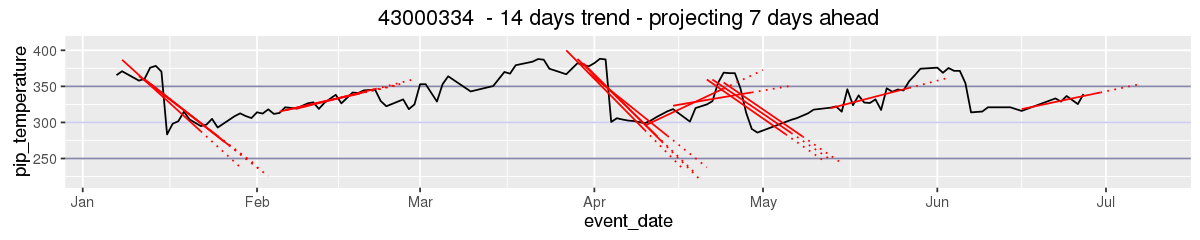

Warning message:
: Removed 15 rows containing missing values (geom_segment).Warning message:
: Removed 15 rows containing missing values (geom_segment).

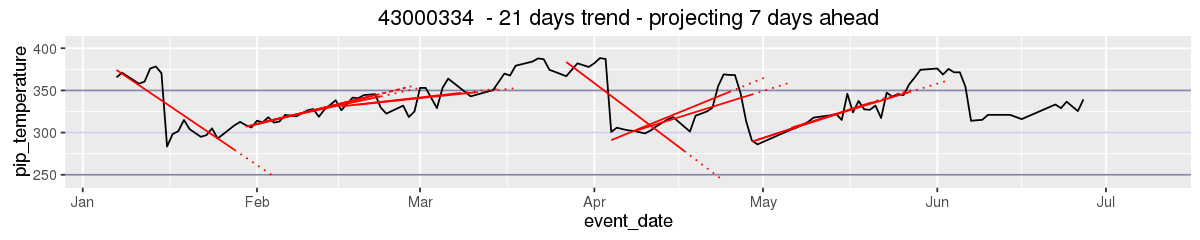

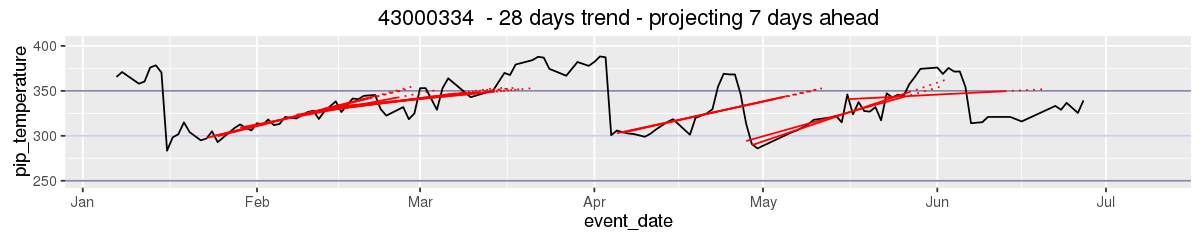

In [133]:
plot_pip_temp_with_trends_and_projection(
    case_1_pip_temp_14_days, 
    upper_limit = 350, 
    lower_limit = 250,
    title = paste(case_1_press,' - 14 days trend - projecting 7 days ahead'))

plot_pip_temp_with_trends_and_projection(
    case_1_pip_temp_21_days, 
    upper_limit = 350, 
    lower_limit = 250,
    title = paste(case_1_press,' - 21 days trend - projecting 7 days ahead'))

plot_pip_temp_with_trends_and_projection(
    case_1_pip_temp_28_days, 
    upper_limit = 350, 
    lower_limit = 250,
    title = paste(case_1_press,' - 28 days trend - projecting 7 days ahead'))

### 6.4 Case 2 - Well-behaved press with different sliding window sizes

In [134]:
case_2_press <- 43000401 # 40000177

In [135]:
case_2_pip_temp_14_days <- slide_press_sensor(
    df_daily, 
    day_sequences_14_days, 
    case_2_press, 
    'pip_temperature', 
    7, 
    upper_limit, 
    lower_limit)

In [136]:
case_2_pip_temp_21_days <- slide_press_sensor(
    df_daily, 
    day_sequences_21_days, 
    case_2_press, 
    'pip_temperature', 
    7, 
    upper_limit, 
    lower_limit)

In [137]:
case_2_pip_temp_28_days <- slide_press_sensor(
    df_daily, 
    day_sequences_28_days, 
    case_2_press, 
    'pip_temperature', 
    7, 
    upper_limit, 
    lower_limit)

Warning message:
: Removed 12 rows containing missing values (geom_segment).Warning message:
: Removed 12 rows containing missing values (geom_segment).Warning message:
: Removed 17 rows containing missing values (geom_segment).Warning message:
: Removed 17 rows containing missing values (geom_segment).

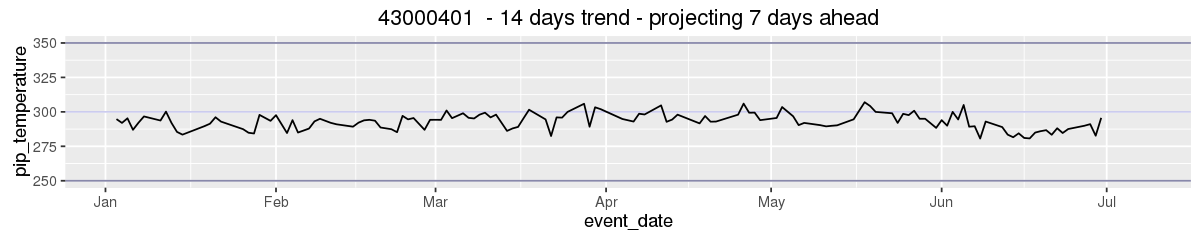

Warning message:
: Removed 25 rows containing missing values (geom_segment).Warning message:
: Removed 25 rows containing missing values (geom_segment).

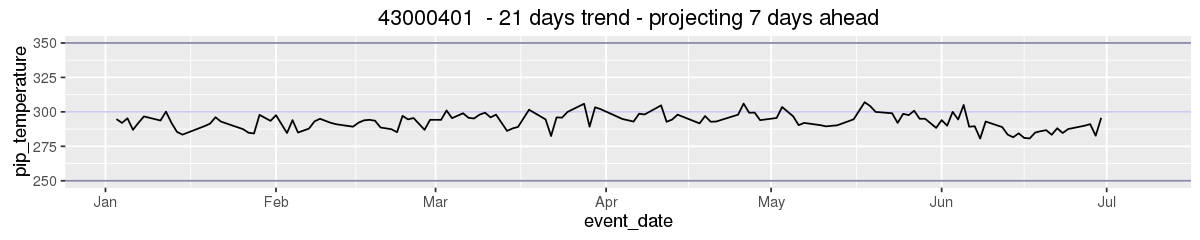

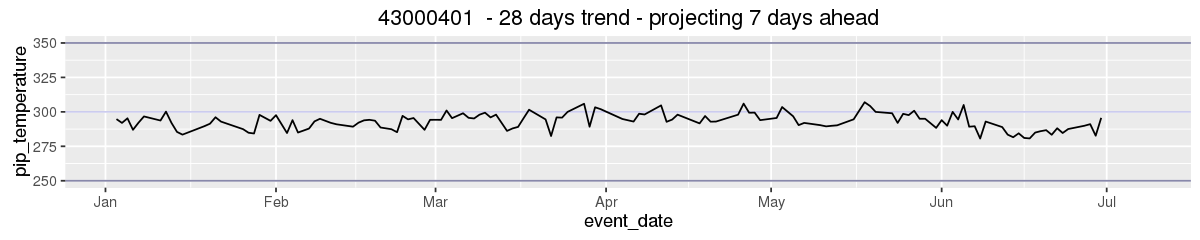

In [138]:
plot_pip_temp_with_trends_and_projection(
    case_2_pip_temp_14_days, 
    upper_limit = 350, 
    lower_limit = 250,
    title = paste(case_2_press,' - 14 days trend - projecting 7 days ahead'))

plot_pip_temp_with_trends_and_projection(
    case_2_pip_temp_21_days, 
    upper_limit = 350, 
    lower_limit = 250,
    title = paste(case_2_press,' - 21 days trend - projecting 7 days ahead'))

plot_pip_temp_with_trends_and_projection(
    case_2_pip_temp_28_days, 
    upper_limit = 350, 
    lower_limit = 250,
    title = paste(case_2_press,' - 28 days trend - projecting 7 days ahead'))

## 7. Final considerations
Different plots show that linear regression can do a good job in detecting long-term trends with proper width and press however it also flags many false-positives specially for the lower threshold.

Recommended next steps to go further in this analysis are:
* Besides maximum continuous gap size, also verify gap frequency in each presses since very few data can lead to poor predictions
* Apply this analysis for other sensor columns such as io_temperature, io_conductivity, etc.
* For each press, write a programa that automatically tries several sliding window widths such as 7, 14, 21 and 28 days and chooses the width that minimizes false positives
* Evaluate effectiveness of the approach described above as an actual valuable business approach